#**PARTE I-- Adquisición y Tratamiento de la Información**

Enfocada en la calidad, transformación y representación de los datos.

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
import os
original_path = "/content/drive/MyDrive/Proyecto Final/merged_dataset"

In [8]:
import os
import random
import numpy as np
from tqdm import tqdm
from PIL import Image

# Skimage
from skimage.feature import hog, local_binary_pattern
from skimage.color import rgb2gray

# OpenCV
import cv2

# MobileNet
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing import image

# Guardado
import joblib

In [11]:
def extract_hog(img):
    gray = rgb2gray(img)
    return hog(gray,
               orientations=9,
               pixels_per_cell=(8,8),
               cells_per_block=(2,2),
               block_norm='L2-Hys')

In [12]:
def extract_lbp(img):
    gray = rgb2gray(img)
    lbp = local_binary_pattern(gray, 8, 1, method='uniform')
    hist, _ = np.histogram(lbp, bins=np.arange(0,11), density=True)
    return hist

In [13]:
def extract_color_hist(img):
    img_rgb = img
    img_hsv = cv2.cvtColor((img_rgb*255).astype(np.uint8), cv2.COLOR_RGB2HSV)
    features = []

    for i in range(3):
        h1 = cv2.calcHist([img_rgb.astype(np.float32)], [i], None, [32], [0,1])
        h2 = cv2.calcHist([img_hsv], [i], None, [32], [0,256])
        features.extend(h1.flatten())
        features.extend(h2.flatten())

    return np.array(features)

In [14]:
mobilenet = MobileNetV2(
    weights="imagenet",
    include_top=False,
    pooling="avg",
    input_shape=(224,224,3)
)

In [15]:
processed_path = "/content/drive/MyDrive/Proyecto Final/dataset_cuadrado"

In [16]:
def extract_hog_128(img):
    gray = rgb2gray(img)
    return hog(gray, orientations=9, pixels_per_cell=(8,8), cells_per_block=(2,2), block_norm='L2-Hys')

def extract_lbp_128(img):
    gray = rgb2gray(img)
    lbp = local_binary_pattern(gray, 8, 1, method="uniform")
    hist, _ = np.histogram(lbp, bins=np.arange(0,11), density=True)
    return hist

def extract_color_128(img):
    img_rgb = img
    img_hsv = cv2.cvtColor((img_rgb*255).astype(np.uint8), cv2.COLOR_RGB2HSV)

    features = []
    for i in range(3):
        hist_rgb = cv2.calcHist([img_rgb.astype(np.float32)], [i], None, [32], [0,1])
        hist_hsv = cv2.calcHist([img_hsv], [i], None, [32], [0,256])
        features.extend(hist_rgb.flatten())
        features.extend(hist_hsv.flatten())
    return np.array(features)

In [19]:
processed_path = "/content/drive/MyDrive/Proyecto Final/dataset_cuadrado"

# Todas las clases
todas_las_clases = sorted(os.listdir(processed_path))

# Seleccionar 70% aleatorio
num_clases = int(len(todas_las_clases) * 0.70)
clases_elegidas = random.sample(todas_las_clases, num_clases)

print(f"Total clases: {len(todas_las_clases)}")
print(f"Clases seleccionadas (70%): {num_clases}")
print("Ejemplo:", clases_elegidas[:10])

Total clases: 169
Clases seleccionadas (70%): 118
Ejemplo: ['Hericium erinaceus', 'Vulpicida pinastri', 'Suillus granulatus', 'Schizophyllum commune', 'Mycena haematopus', 'Lactarius turpis', 'Daedaleopsis confragosa', 'Agaricus xanthodermus', 'Retiboletus ornatipes', 'Stereum ostrea']


In [19]:
hog_features = []
lbp_features = []
color_features = []
mobile_features = []
labels = []

for clase in clases_elegidas:
    folder = os.path.join(processed_path, clase)
    imgs = os.listdir(folder)

    # Seleccionar 70% aleatorio de imágenes
    total_imgs = len(imgs)
    seleccion_imgs = int(total_imgs * 0.70)
    imgs_elegidas = random.sample(imgs, seleccion_imgs)

    print(f"\nClase → {clase}:  {seleccion_imgs}/{total_imgs} imágenes (70%)")

    for img_name in tqdm(imgs_elegidas, desc=f"Extrayendo {clase}"):
        try:
            path = os.path.join(folder, img_name)

            # Imagen 128x128
            img = Image.open(path).convert("RGB")
            img_128 = np.array(img) / 255.0

            # Características clásicas
            hog_features.append(extract_hog_128(img_128))
            lbp_features.append(extract_lbp_128(img_128))
            color_features.append(extract_color_128(img_128))

            # MobileNet → 224x224
            img_224 = img.resize((224,224))
            img_224 = image.img_to_array(img_224)
            img_224 = preprocess_input(img_224)
            deep = mobilenet.predict(np.expand_dims(img_224, axis=0), verbose=0)

            mobile_features.append(deep.flatten())
            labels.append(clase)

        except Exception as e:
            print("Error con:", path, e)


Clase → Cantharellus californicus:  227/325 imágenes (70%)


Extrayendo Cantharellus californicus: 100%|██████████| 227/227 [00:43<00:00,  5.20it/s]



Clase → Phellinus igniarius:  234/335 imágenes (70%)


Extrayendo Phellinus igniarius: 100%|██████████| 234/234 [00:42<00:00,  5.49it/s]



Clase → Amanita pantherina:  238/341 imágenes (70%)


Extrayendo Amanita pantherina: 100%|██████████| 238/238 [00:44<00:00,  5.33it/s]



Clase → Tricholoma murrillianum:  197/282 imágenes (70%)


Extrayendo Tricholoma murrillianum: 100%|██████████| 197/197 [00:35<00:00,  5.54it/s]



Clase → Hypholoma lateritium:  427/611 imágenes (70%)


Extrayendo Hypholoma lateritium: 100%|██████████| 427/427 [01:30<00:00,  4.71it/s]



Clase → Schizophyllum commune:  957/1368 imágenes (70%)


Extrayendo Schizophyllum commune: 100%|██████████| 957/957 [03:18<00:00,  4.83it/s]



Clase → Amanita rubescens:  371/530 imágenes (70%)


Extrayendo Amanita rubescens: 100%|██████████| 371/371 [01:15<00:00,  4.91it/s]



Clase → Agaricus xanthodermus:  212/304 imágenes (70%)


Extrayendo Agaricus xanthodermus: 100%|██████████| 212/212 [00:37<00:00,  5.61it/s]



Clase → Trametes gibbosa:  172/247 imágenes (70%)


Extrayendo Trametes gibbosa: 100%|██████████| 172/172 [00:33<00:00,  5.09it/s]



Clase → Fomitopsis betulina:  1110/1587 imágenes (70%)


Extrayendo Fomitopsis betulina: 100%|██████████| 1110/1110 [03:40<00:00,  5.03it/s]



Clase → Entoloma abortivum:  206/295 imágenes (70%)


Extrayendo Entoloma abortivum: 100%|██████████| 206/206 [00:36<00:00,  5.62it/s]



Clase → Daedaleopsis confragosa:  561/802 imágenes (70%)


Extrayendo Daedaleopsis confragosa: 100%|██████████| 561/561 [01:49<00:00,  5.12it/s]



Clase → Verpa bohemica:  549/785 imágenes (70%)


Extrayendo Verpa bohemica: 100%|██████████| 549/549 [01:45<00:00,  5.20it/s]



Clase → Tylopilus rubrobrunneus:  204/292 imágenes (70%)


Extrayendo Tylopilus rubrobrunneus: 100%|██████████| 204/204 [00:40<00:00,  5.09it/s]



Clase → Leucoagaricus leucothites:  179/257 imágenes (70%)


Extrayendo Leucoagaricus leucothites: 100%|██████████| 179/179 [00:34<00:00,  5.23it/s]



Clase → Clitocybe nebularis:  319/456 imágenes (70%)


Extrayendo Clitocybe nebularis: 100%|██████████| 319/319 [01:02<00:00,  5.12it/s]



Clase → Stereum ostrea:  212/303 imágenes (70%)


Extrayendo Stereum ostrea: 100%|██████████| 212/212 [00:39<00:00,  5.36it/s]



Clase → Ganoderma applanatum:  809/1156 imágenes (70%)


Extrayendo Ganoderma applanatum: 100%|██████████| 809/809 [02:37<00:00,  5.13it/s]



Clase → Mutinus ravenelii:  191/273 imágenes (70%)


Extrayendo Mutinus ravenelii: 100%|██████████| 191/191 [00:37<00:00,  5.09it/s]



Clase → Omphalotus olivascens:  196/281 imágenes (70%)


Extrayendo Omphalotus olivascens: 100%|██████████| 196/196 [00:38<00:00,  5.15it/s]



Clase → Lobaria pulmonaria:  434/620 imágenes (70%)


Extrayendo Lobaria pulmonaria: 100%|██████████| 434/434 [01:25<00:00,  5.05it/s]



Clase → Vulpicida pinastri:  603/862 imágenes (70%)


Extrayendo Vulpicida pinastri: 100%|██████████| 603/603 [01:57<00:00,  5.14it/s]



Clase → Coprinopsis atramentaria:  198/284 imágenes (70%)


Extrayendo Coprinopsis atramentaria: 100%|██████████| 198/198 [00:37<00:00,  5.23it/s]



Clase → Psilocybe ovoideocystidiata:  175/251 imágenes (70%)


Extrayendo Psilocybe ovoideocystidiata: 100%|██████████| 175/175 [00:32<00:00,  5.35it/s]



Clase → Lepista nuda:  199/285 imágenes (70%)


Extrayendo Lepista nuda: 100%|██████████| 199/199 [00:38<00:00,  5.19it/s]



Clase → Boletus pallidus:  224/320 imágenes (70%)


Extrayendo Boletus pallidus: 100%|██████████| 224/224 [00:41<00:00,  5.36it/s]



Clase → Gyromitra gigas:  1017/1453 imágenes (70%)


Extrayendo Gyromitra gigas: 100%|██████████| 1017/1017 [03:31<00:00,  4.80it/s]



Clase → Amanita muscaria:  3203/4577 imágenes (70%)


Extrayendo Amanita muscaria: 100%|██████████| 3203/3203 [10:58<00:00,  4.86it/s]



Clase → Pholiota squarrosa:  237/340 imágenes (70%)


Extrayendo Pholiota squarrosa: 100%|██████████| 237/237 [00:47<00:00,  5.01it/s]



Clase → Gymnopilus luteofolius:  170/243 imágenes (70%)


Extrayendo Gymnopilus luteofolius: 100%|██████████| 170/170 [00:33<00:00,  5.07it/s]



Clase → Physcia adscendens:  258/369 imágenes (70%)


Extrayendo Physcia adscendens: 100%|██████████| 258/258 [00:51<00:00,  5.03it/s]



Clase → Lactarius deliciosus:  194/278 imágenes (70%)


Extrayendo Lactarius deliciosus: 100%|██████████| 194/194 [00:37<00:00,  5.17it/s]



Clase → Armillaria borealis:  189/270 imágenes (70%)


Extrayendo Armillaria borealis: 100%|██████████| 189/189 [00:36<00:00,  5.24it/s]



Clase → Amanita velosa:  197/282 imágenes (70%)


Extrayendo Amanita velosa: 100%|██████████| 197/197 [00:39<00:00,  5.05it/s]



Clase → Sarcoscypha austriaca:  273/391 imágenes (70%)


Extrayendo Sarcoscypha austriaca: 100%|██████████| 273/273 [00:53<00:00,  5.12it/s]



Clase → Retiboletus ornatipes:  206/295 imágenes (70%)


Extrayendo Retiboletus ornatipes: 100%|██████████| 206/206 [00:40<00:00,  5.13it/s]



Clase → Lactarius turpis:  186/267 imágenes (70%)


Extrayendo Lactarius turpis: 100%|██████████| 186/186 [00:38<00:00,  4.89it/s]



Clase → Cantharellus cinnabarinus:  233/333 imágenes (70%)


Extrayendo Cantharellus cinnabarinus: 100%|██████████| 233/233 [00:48<00:00,  4.84it/s]



Clase → Leucoagaricus americanus:  184/264 imágenes (70%)


Extrayendo Leucoagaricus americanus: 100%|██████████| 184/184 [00:36<00:00,  4.97it/s]



Clase → Gyromitra infula:  218/312 imágenes (70%)


Extrayendo Gyromitra infula: 100%|██████████| 218/218 [00:42<00:00,  5.15it/s]



Clase → Parmelia sulcata:  1847/2639 imágenes (70%)


Extrayendo Parmelia sulcata: 100%|██████████| 1847/1847 [06:46<00:00,  4.54it/s]



Clase → Clitocybe nuda:  333/477 imágenes (70%)


Extrayendo Clitocybe nuda: 100%|██████████| 333/333 [01:06<00:00,  5.02it/s]



Clase → Hypholoma fasciculare:  374/535 imágenes (70%)


Extrayendo Hypholoma fasciculare: 100%|██████████| 374/374 [01:15<00:00,  4.93it/s]



Clase → Lycoperdon perlatum:  1006/1438 imágenes (70%)


Extrayendo Lycoperdon perlatum: 100%|██████████| 1006/1006 [03:32<00:00,  4.74it/s]



Clase → Sarcomyxa serotina:  376/538 imágenes (70%)


Extrayendo Sarcomyxa serotina: 100%|██████████| 376/376 [01:19<00:00,  4.73it/s]



Clase → Inonotus obliquus:  653/933 imágenes (70%)


Extrayendo Inonotus obliquus: 100%|██████████| 653/653 [02:17<00:00,  4.74it/s]



Clase → Amanita amerirubescens:  234/335 imágenes (70%)


Extrayendo Amanita amerirubescens: 100%|██████████| 234/234 [00:42<00:00,  5.48it/s]



Clase → Peltigera aphthosa:  194/278 imágenes (70%)


Extrayendo Peltigera aphthosa: 100%|██████████| 194/194 [00:40<00:00,  4.81it/s]



Clase → Pholiota aurivella:  284/407 imágenes (70%)


Extrayendo Pholiota aurivella: 100%|██████████| 284/284 [00:58<00:00,  4.85it/s]



Clase → Ganoderma curtisii:  181/259 imágenes (70%)


Extrayendo Ganoderma curtisii: 100%|██████████| 181/181 [00:36<00:00,  4.93it/s]



Clase → Calycina citrina:  418/598 imágenes (70%)


Extrayendo Calycina citrina: 100%|██████████| 418/418 [01:27<00:00,  4.79it/s]



Clase → Leccinum versipelle:  301/430 imágenes (70%)


Extrayendo Leccinum versipelle: 100%|██████████| 301/301 [00:59<00:00,  5.04it/s]



Clase → Omphalotus illudens:  216/309 imágenes (70%)


Extrayendo Omphalotus illudens: 100%|██████████| 216/216 [00:41<00:00,  5.18it/s]



Clase → Crucibulum laeve:  397/568 imágenes (70%)


Extrayendo Crucibulum laeve: 100%|██████████| 397/397 [01:22<00:00,  4.81it/s]



Clase → Coprinus comatus:  1130/1615 imágenes (70%)


Extrayendo Coprinus comatus: 100%|██████████| 1130/1130 [04:01<00:00,  4.68it/s]



Clase → Macrolepiota procera:  630/900 imágenes (70%)


Extrayendo Macrolepiota procera: 100%|██████████| 630/630 [02:15<00:00,  4.64it/s]



Clase → Psilocybe azurescens:  177/253 imágenes (70%)


Extrayendo Psilocybe azurescens: 100%|██████████| 177/177 [00:35<00:00,  4.94it/s]



Clase → Stereum hirsutum:  213/305 imágenes (70%)


Extrayendo Stereum hirsutum: 100%|██████████| 213/213 [00:42<00:00,  5.06it/s]



Clase → Calocera viscosa:  295/422 imágenes (70%)


Extrayendo Calocera viscosa: 100%|██████████| 295/295 [00:59<00:00,  4.97it/s]



Clase → Leccinum scabrum:  1185/1693 imágenes (70%)


Extrayendo Leccinum scabrum: 100%|██████████| 1185/1185 [04:18<00:00,  4.59it/s]



Clase → Laetiporus sulphureus:  1812/2590 imágenes (70%)


Extrayendo Laetiporus sulphureus: 100%|██████████| 1812/1812 [06:35<00:00,  4.58it/s]



Clase → Amanita calyptroderma:  228/326 imágenes (70%)


Extrayendo Amanita calyptroderma: 100%|██████████| 228/228 [00:47<00:00,  4.84it/s]



Clase → Psilocybe cyanescens:  184/263 imágenes (70%)


Extrayendo Psilocybe cyanescens: 100%|██████████| 184/184 [00:37<00:00,  4.94it/s]



Clase → Suillus spraguei:  200/287 imágenes (70%)


Extrayendo Suillus spraguei: 100%|██████████| 200/200 [00:39<00:00,  5.04it/s]



Clase → Cerioporus squamosus:  1470/2100 imágenes (70%)


Extrayendo Cerioporus squamosus: 100%|██████████| 1470/1470 [05:24<00:00,  4.54it/s]



Clase → Phlebia tremellosa:  200/286 imágenes (70%)


Extrayendo Phlebia tremellosa: 100%|██████████| 200/200 [00:39<00:00,  5.08it/s]



Clase → Artomyces pyxidatus:  891/1273 imágenes (70%)


Extrayendo Artomyces pyxidatus: 100%|██████████| 891/891 [02:57<00:00,  5.01it/s]



Clase → Tapinella atrotomentosa:  209/299 imágenes (70%)


Extrayendo Tapinella atrotomentosa: 100%|██████████| 209/209 [00:40<00:00,  5.12it/s]



Clase → Peltigera praetextata:  203/291 imágenes (70%)


Extrayendo Peltigera praetextata: 100%|██████████| 203/203 [00:41<00:00,  4.87it/s]



Clase → Cantharellus cibarius:  590/843 imágenes (70%)


Extrayendo Cantharellus cibarius: 100%|██████████| 590/590 [02:01<00:00,  4.86it/s]



Clase → Coprinellus disseminatus:  318/455 imágenes (70%)


Extrayendo Coprinellus disseminatus: 100%|██████████| 318/318 [01:03<00:00,  5.03it/s]



Clase → Stropharia aeruginosa:  235/336 imágenes (70%)


Extrayendo Stropharia aeruginosa: 100%|██████████| 235/235 [00:46<00:00,  5.04it/s]



Clase → Phaeophyscia orbicularis:  170/244 imágenes (70%)


Extrayendo Phaeophyscia orbicularis: 100%|██████████| 170/170 [00:34<00:00,  4.87it/s]



Clase → Coprinopsis lagopus:  168/241 imágenes (70%)


Extrayendo Coprinopsis lagopus: 100%|██████████| 168/168 [00:32<00:00,  5.15it/s]



Clase → Mycena leaiana:  222/318 imágenes (70%)


Extrayendo Mycena leaiana: 100%|██████████| 222/222 [00:42<00:00,  5.19it/s]



Clase → Chondrostereum purpureum:  228/326 imágenes (70%)


Extrayendo Chondrostereum purpureum: 100%|██████████| 228/228 [00:47<00:00,  4.78it/s]



Clase → Hypomyces lactifluorum:  229/328 imágenes (70%)


Extrayendo Hypomyces lactifluorum: 100%|██████████| 229/229 [00:47<00:00,  4.79it/s]



Clase → Pseudevernia furfuracea:  312/446 imágenes (70%)


Extrayendo Pseudevernia furfuracea: 100%|██████████| 312/312 [01:03<00:00,  4.90it/s]



Clase → Merulius tremellosus:  274/392 imágenes (70%)


Extrayendo Merulius tremellosus: 100%|██████████| 274/274 [00:54<00:00,  5.03it/s]



Clase → Chlorociboria aeruginascens:  237/340 imágenes (70%)


Extrayendo Chlorociboria aeruginascens: 100%|██████████| 237/237 [00:46<00:00,  5.10it/s]



Clase → Stropharia ambigua:  205/293 imágenes (70%)


Extrayendo Stropharia ambigua: 100%|██████████| 205/205 [00:40<00:00,  5.00it/s]



Clase → Imleria badia:  205/294 imágenes (70%)


Extrayendo Imleria badia: 100%|██████████| 205/205 [00:41<00:00,  4.94it/s]



Clase → Fomitopsis mounceae:  186/267 imágenes (70%)


Extrayendo Fomitopsis mounceae: 100%|██████████| 186/186 [00:40<00:00,  4.64it/s]



Clase → Trametes hirsuta:  196/280 imágenes (70%)


Extrayendo Trametes hirsuta: 100%|██████████| 196/196 [00:39<00:00,  5.00it/s]



Clase → Coltricia perennis:  173/248 imágenes (70%)


Extrayendo Coltricia perennis: 100%|██████████| 173/173 [00:37<00:00,  4.63it/s]



Clase → Tricholomopsis rutilans:  366/523 imágenes (70%)


Extrayendo Tricholomopsis rutilans: 100%|██████████| 366/366 [01:18<00:00,  4.67it/s]



Clase → Suillus granulatus:  319/456 imágenes (70%)


Extrayendo Suillus granulatus: 100%|██████████| 319/319 [01:05<00:00,  4.87it/s]



Clase → Psathyrella candolleana:  169/242 imágenes (70%)


Extrayendo Psathyrella candolleana: 100%|██████████| 169/169 [00:31<00:00,  5.28it/s]



Clase → Psilocybe cubensis:  174/249 imágenes (70%)


Extrayendo Psilocybe cubensis: 100%|██████████| 174/174 [00:35<00:00,  4.97it/s]



Clase → Urnula craterium:  209/299 imágenes (70%)


Extrayendo Urnula craterium: 100%|██████████| 209/209 [00:40<00:00,  5.18it/s]



Clase → Amanita brunnescens:  214/306 imágenes (70%)


Extrayendo Amanita brunnescens: 100%|██████████| 214/214 [00:42<00:00,  5.08it/s]



Clase → Suillus grevillei:  170/243 imágenes (70%)


Extrayendo Suillus grevillei: 100%|██████████| 170/170 [00:33<00:00,  5.15it/s]



Clase → Amanita augusta:  231/331 imágenes (70%)


Extrayendo Amanita augusta: 100%|██████████| 231/231 [00:41<00:00,  5.58it/s]



Clase → Boletus edulis:  1026/1467 imágenes (70%)


Extrayendo Boletus edulis: 100%|██████████| 1026/1026 [03:43<00:00,  4.60it/s]



Clase → Ganoderma oregonense:  171/245 imágenes (70%)


Extrayendo Ganoderma oregonense: 100%|██████████| 171/171 [00:35<00:00,  4.86it/s]



Clase → Chlorophyllum molybdites:  164/235 imágenes (70%)


Extrayendo Chlorophyllum molybdites: 100%|██████████| 164/164 [00:32<00:00,  5.12it/s]



Clase → Fomitopsis pinicola:  3563/5090 imágenes (70%)


Extrayendo Fomitopsis pinicola: 100%|██████████| 3563/3563 [13:01<00:00,  4.56it/s]



Clase → Sarcosoma globosum:  196/280 imágenes (70%)


Extrayendo Sarcosoma globosum: 100%|██████████| 196/196 [00:39<00:00,  4.99it/s]



Clase → Kuehneromyces mutabilis:  463/662 imágenes (70%)


Extrayendo Kuehneromyces mutabilis: 100%|██████████| 463/463 [01:37<00:00,  4.77it/s]



Clase → Nectria cinnabarina:  223/319 imágenes (70%)


Extrayendo Nectria cinnabarina: 100%|██████████| 223/223 [00:45<00:00,  4.86it/s]



Clase → Rhytisma acerinum:  560/801 imágenes (70%)


Extrayendo Rhytisma acerinum: 100%|██████████| 560/560 [02:01<00:00,  4.62it/s]



Clase → Xanthoria parietina:  4079/5828 imágenes (70%)


Extrayendo Xanthoria parietina: 100%|██████████| 4079/4079 [14:48<00:00,  4.59it/s]



Clase → Amanita phalloides:  223/319 imágenes (70%)


Extrayendo Amanita phalloides: 100%|██████████| 223/223 [00:47<00:00,  4.74it/s]



Clase → Panaeolus papilionaceus:  154/220 imágenes (70%)


Extrayendo Panaeolus papilionaceus: 100%|██████████| 154/154 [00:32<00:00,  4.73it/s]



Clase → Trametes ochracea:  186/266 imágenes (70%)


Extrayendo Trametes ochracea: 100%|██████████| 186/186 [00:38<00:00,  4.79it/s]



Clase → Panellus stipticus:  365/522 imágenes (70%)


Extrayendo Panellus stipticus: 100%|██████████| 365/365 [01:16<00:00,  4.76it/s]



Clase → Graphis scripta:  237/339 imágenes (70%)


Extrayendo Graphis scripta: 100%|██████████| 237/237 [00:46<00:00,  5.06it/s]



Clase → Leccinum aurantiacum:  385/550 imágenes (70%)


Extrayendo Leccinum aurantiacum: 100%|██████████| 385/385 [01:17<00:00,  4.99it/s]



Clase → Lycoperdon pyriforme:  210/300 imágenes (70%)


Extrayendo Lycoperdon pyriforme: 100%|██████████| 210/210 [00:41<00:00,  5.12it/s]



Clase → Cladonia fimbriata:  218/312 imágenes (70%)


Extrayendo Cladonia fimbriata: 100%|██████████| 218/218 [00:46<00:00,  4.65it/s]



Clase → Cladonia stellaris:  251/359 imágenes (70%)


Extrayendo Cladonia stellaris: 100%|██████████| 251/251 [00:52<00:00,  4.81it/s]



Clase → Grifola frondosa:  207/297 imágenes (70%)


Extrayendo Grifola frondosa: 100%|██████████| 207/207 [00:42<00:00,  4.92it/s]



Clase → Phaeolus schweinitzii:  203/291 imágenes (70%)


Extrayendo Phaeolus schweinitzii: 100%|██████████| 203/203 [00:40<00:00,  5.00it/s]



Clase → Volvopluteus gloiocephalus:  161/231 imágenes (70%)


Extrayendo Volvopluteus gloiocephalus: 100%|██████████| 161/161 [00:31<00:00,  5.18it/s]



Clase → Apioperdon pyriforme:  710/1015 imágenes (70%)


Extrayendo Apioperdon pyriforme: 100%|██████████| 710/710 [02:23<00:00,  4.96it/s]



Clase → Hericium coralloides:  633/905 imágenes (70%)


Extrayendo Hericium coralloides: 100%|██████████| 633/633 [02:11<00:00,  4.80it/s]



Clase → Psilocybe pelliculosa:  204/292 imágenes (70%)


Extrayendo Psilocybe pelliculosa: 100%|██████████| 204/204 [00:42<00:00,  4.76it/s]



Clase → Trametes betulina:  203/291 imágenes (70%)


Extrayendo Trametes betulina: 100%|██████████| 203/203 [00:41<00:00,  4.91it/s]


In [21]:
BASE = "/content/drive/MyDrive/Proyecto Final/caracteristicas_70clases_70imgs"
os.makedirs(BASE, exist_ok=True)

joblib.dump(hog_features, f"{BASE}/features_hog.pkl")
joblib.dump(lbp_features, f"{BASE}/features_lbp.pkl")
joblib.dump(color_features, f"{BASE}/features_color.pkl")
joblib.dump(mobile_features, f"{BASE}/features_mobilenet.pkl")
joblib.dump(labels, f"{BASE}/labels.pkl")
joblib.dump(clases_elegidas, f"{BASE}/classes.pkl")

print("\n¡Características guardadas correctamente!")
print(f"Clases seleccionadas: {len(clases_elegidas)}")
print("Guardado en:", BASE)

NameError: name 'hog_features' is not defined

**Carpeta nueva**

In [23]:
BASE = "/content/drive/MyDrive/Proyecto Final/caracteristicas_70clases_70imgs"

hog_features = joblib.load(f"{BASE}/features_hog.pkl")
lbp_features = joblib.load(f"{BASE}/features_lbp.pkl")
color_features = joblib.load(f"{BASE}/features_color.pkl")
mobile_features = joblib.load(f"{BASE}/features_mobilenet.pkl")
labels = joblib.load(f"{BASE}/labels.pkl")
classes = joblib.load(f"{BASE}/classes.pkl")

print("Datos cargados correctamente.")
print("Total muestras:", len(labels))
print("Clases seleccionadas:", len(classes))

Datos cargados correctamente.
Total muestras: 52805
Clases seleccionadas: 118


In [2]:
import matplotlib.pyplot as plt
import random
from PIL import Image

plt.figure(figsize=(12,12))

for i in range(25):
    # Seleccionar clase aleatoria
    clase = random.choice(classes)
    carpeta = os.path.join(processed_path, clase)

    # Seleccionar imagen
    img_name = random.choice(os.listdir(carpeta))
    img_path = os.path.join(carpeta, img_name)
    img = Image.open(img_path)

    plt.subplot(5,5,i+1)
    plt.imshow(img)
    plt.title(clase, fontsize=8)
    plt.axis("off")

plt.suptitle("Muestreo visual de 25 imágenes del dataset (5×5)", fontsize=16)
plt.show()

NameError: name 'classes' is not defined

<Figure size 1200x1200 with 0 Axes>

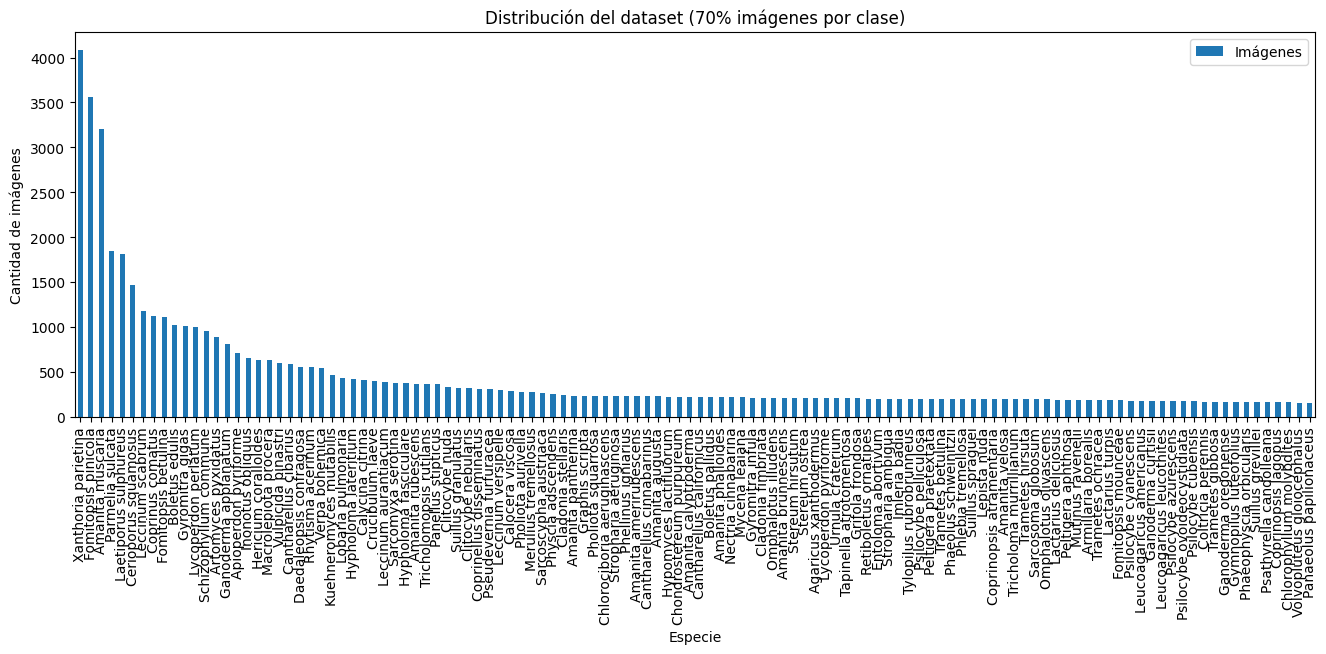

In [23]:
import pandas as pd
import matplotlib.pyplot as plt

conteo = {clase: labels.count(clase) for clase in classes}

df_conteo = pd.DataFrame.from_dict(conteo, orient="index", columns=["Imágenes"])

df_conteo.sort_values("Imágenes", ascending=False).plot(
    kind="bar", figsize=(16,5)
)
plt.title("Distribución del dataset (70% imágenes por clase)")
plt.xlabel("Especie")
plt.ylabel("Cantidad de imágenes")
plt.show()

Clase: Apioperdon pyriforme
Imagen: 4498medium.jpg
Dimensión MobileNet: 1280


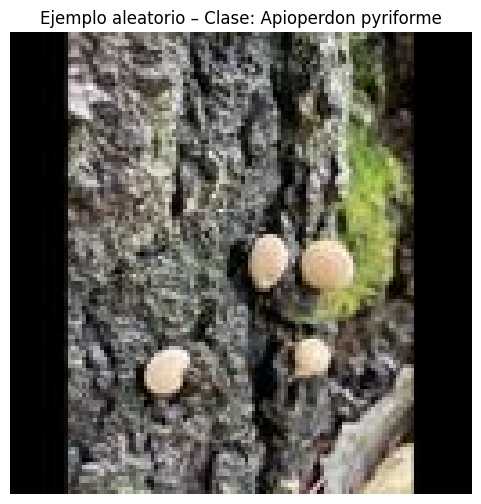


HOG (primeros 20 valores):
 [0.         0.         0.         0.         0.00687233 0.
 0.         0.         0.         0.         0.         0.
 0.         0.00687233 0.         0.         0.         0.
 0.02261387 0.00859041]

LBP:
 [0.05957031 0.06671143 0.05877686 0.0970459  0.13378906 0.09350586
 0.05621338 0.0614624  0.26574707 0.10717773]

Color histogram (primeros 20 valores):
 [4219.  316.  365.  493.  567.  658.  725.  683.  708.  717.  610.  541.
  528.  448.  405.  395.  319.  325.  275.  228.]

MobileNet embedding (primeros 20 valores):
 [0.26636708 0.18429768 0.0265651  0.         0.01125176 0.
 1.795814   0.6038185  2.3185587  0.11700013 0.         0.
 0.13974936 1.1565497  0.01196919 0.12763505 0.         0.
 0.49498138 0.35122555]


In [24]:
import numpy as np
import matplotlib.pyplot as plt

# Elegir índice aleatorio
idx = random.randint(0, len(labels)-1)

clase = labels[idx]
# Encontrar una imagen correspondiente
carpeta = os.path.join(processed_path, clase)
img_name = random.choice(os.listdir(carpeta))
img_path = os.path.join(carpeta, img_name)
img = Image.open(img_path)

print("Clase:", clase)
print("Imagen:", img_name)
print("Dimensión MobileNet:", len(mobile_features[idx]))

plt.figure(figsize=(6,6))
plt.imshow(img)
plt.title(f"Ejemplo aleatorio – Clase: {clase}")
plt.axis("off")
plt.show()

print("\nHOG (primeros 20 valores):\n", hog_features[idx][:20])
print("\nLBP:\n", lbp_features[idx])
print("\nColor histogram (primeros 20 valores):\n", color_features[idx][:20])
print("\nMobileNet embedding (primeros 20 valores):\n", mobile_features[idx][:20])

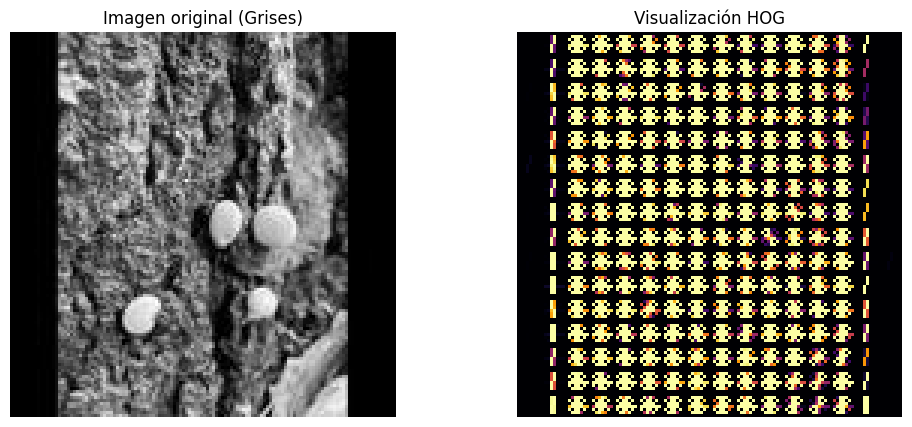

In [25]:
from skimage import exposure

img_gray = rgb2gray(np.array(img) / 255.0)

hog_vis, hog_image = hog(
    img_gray,
    orientations=9,
    pixels_per_cell=(8,8),
    cells_per_block=(2,2),
    block_norm='L2-Hys',
    visualize=True
)

hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0,0.02))

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.imshow(img_gray, cmap='gray')
plt.title("Imagen original (Grises)")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(hog_image_rescaled, cmap='inferno')
plt.title("Visualización HOG")
plt.axis("off")

plt.show()

/usr/local/lib/python3.12/dist-packages/skimage/feature/texture.py:385: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


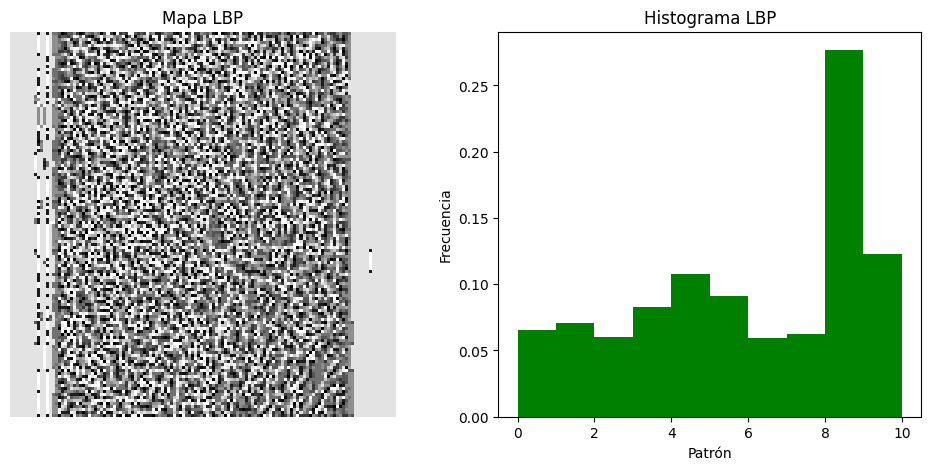

In [26]:
lbp_map = local_binary_pattern(img_gray, P=8, R=1, method="uniform")

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.imshow(lbp_map, cmap='gray')
plt.title("Mapa LBP")
plt.axis("off")

plt.subplot(1,2,2)
plt.hist(lbp_map.ravel(), bins=np.arange(0,11), density=True, color='green')
plt.title("Histograma LBP")
plt.xlabel("Patrón")
plt.ylabel("Frecuencia")
plt.show()

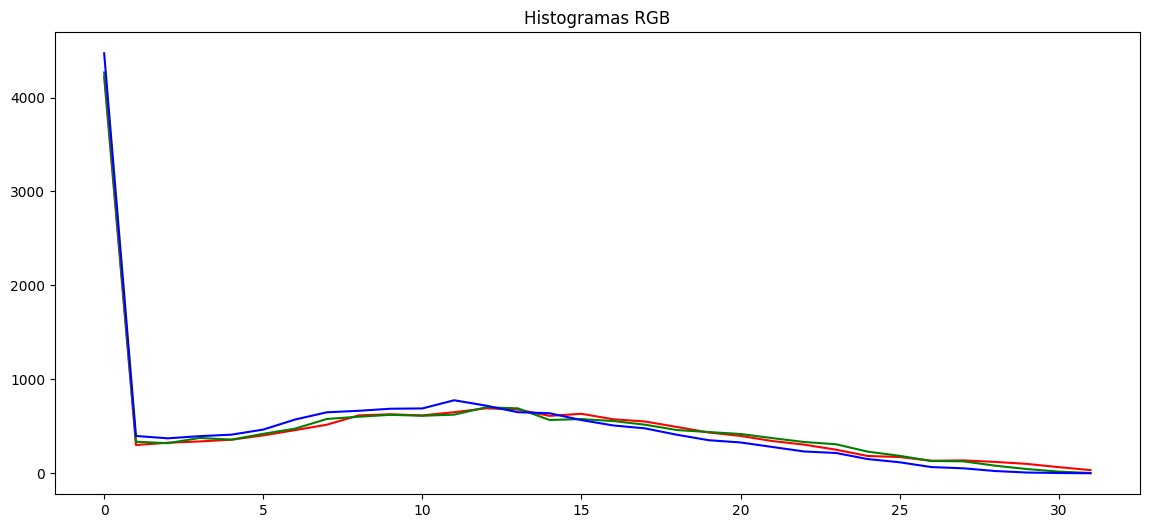

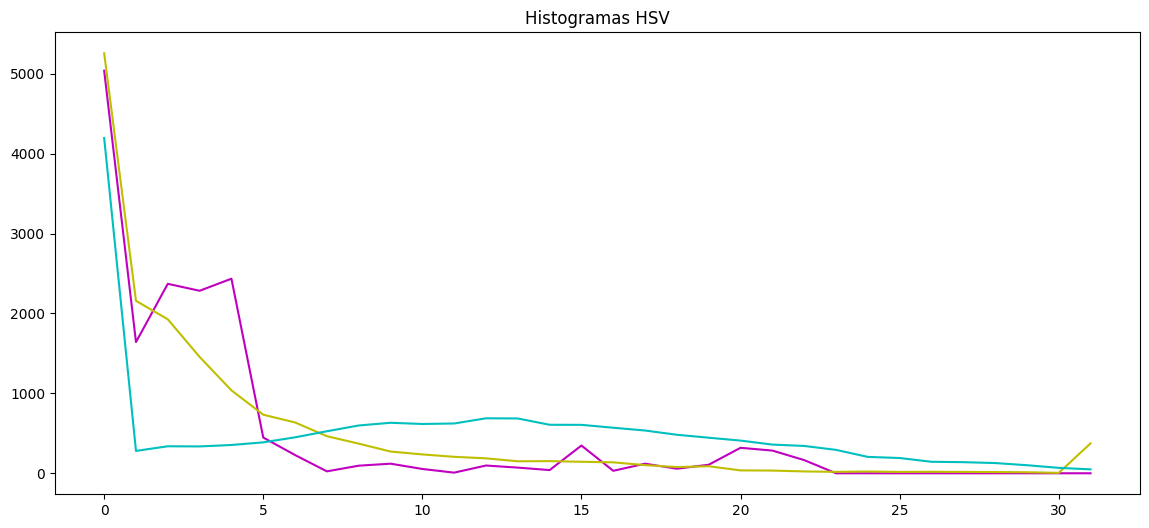

In [27]:
img_np = np.array(img).astype(np.float32) / 255.0
img_hsv = cv2.cvtColor((img_np*255).astype(np.uint8), cv2.COLOR_RGB2HSV)

plt.figure(figsize=(14,6))

# RGB
for i, color in enumerate(['red', 'green', 'blue']):
    hist = cv2.calcHist([img_np.astype(np.float32)], [i], None, [32], [0,1])
    plt.plot(hist, color=color)

plt.title("Histogramas RGB")
plt.show()

# HSV
plt.figure(figsize=(14,6))
for i, color in enumerate(['m', 'y', 'c']):
    hist = cv2.calcHist([img_hsv], [i], None, [32], [0,256])
    plt.plot(hist, color=color)

plt.title("Histogramas HSV")
plt.show()

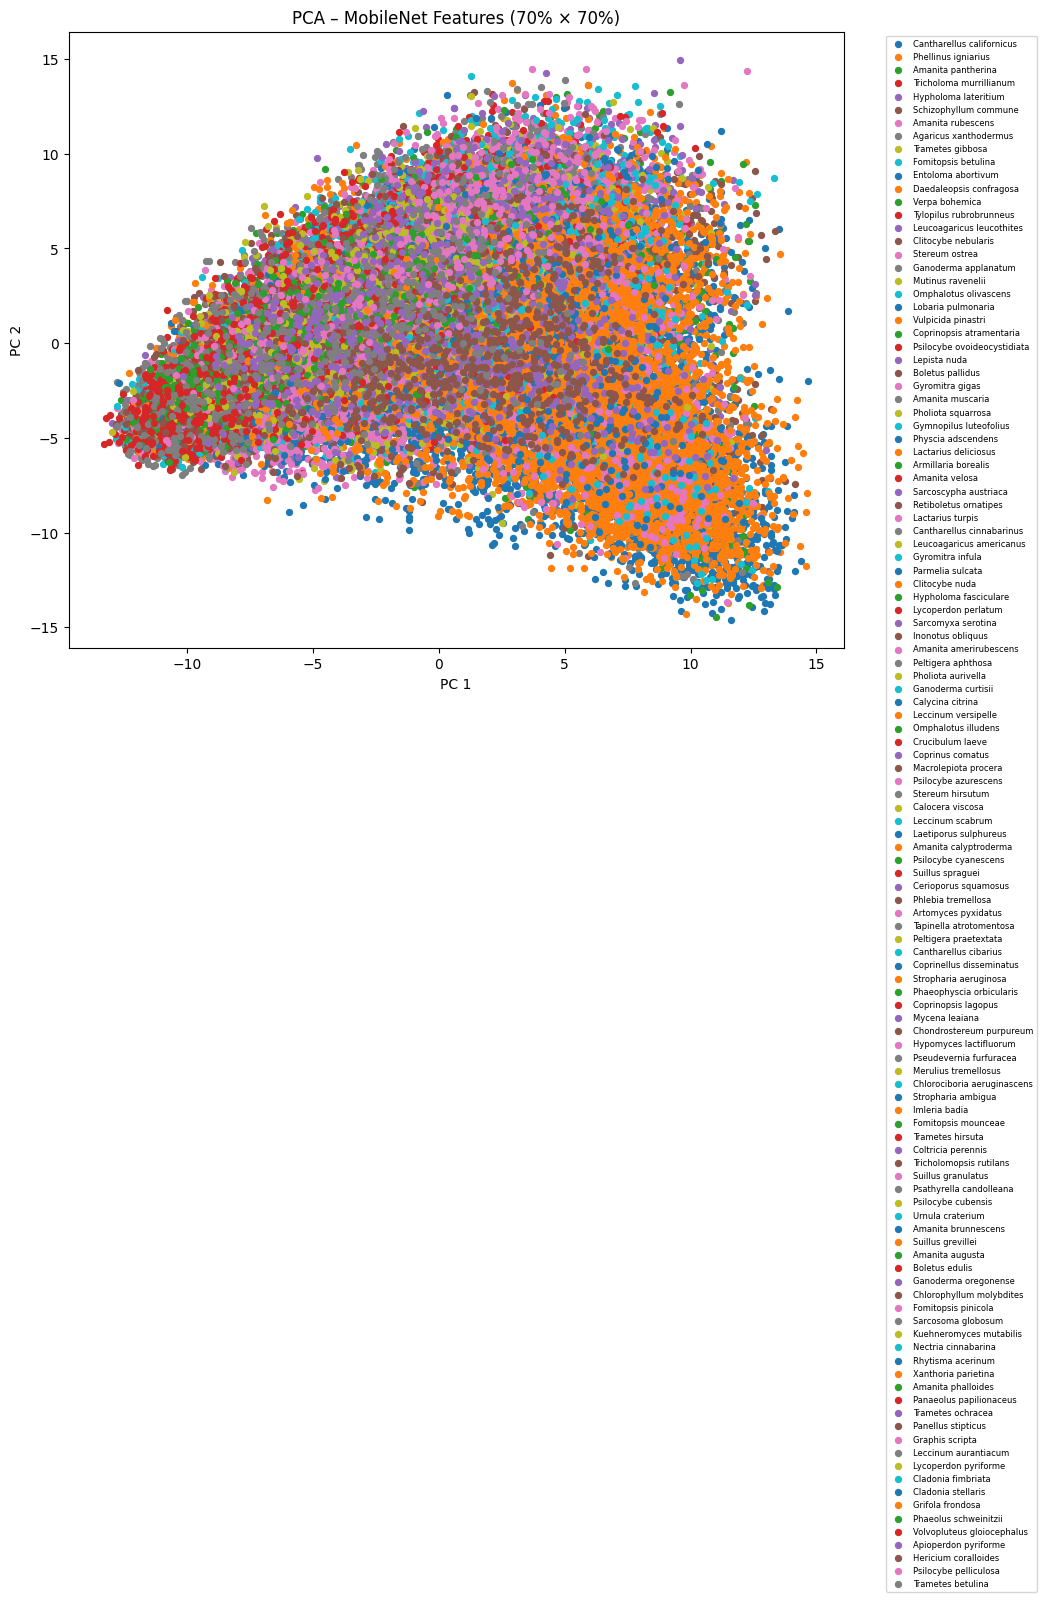

In [28]:
from sklearn.decomposition import PCA

X_mobile = np.array(mobile_features)
pca = PCA(n_components=2)
pca_result = pca.fit_transform(X_mobile)

plt.figure(figsize=(10,8))
for clase in classes:
    idxs = [i for i, c in enumerate(labels) if c == clase]
    plt.scatter(pca_result[idxs,0], pca_result[idxs,1], s=18, label=clase)

plt.title("PCA – MobileNet Features (70% × 70%)")
plt.xlabel("PC 1")
plt.ylabel("PC 2")
plt.legend(bbox_to_anchor=(1.05,1), fontsize=6)
plt.show()

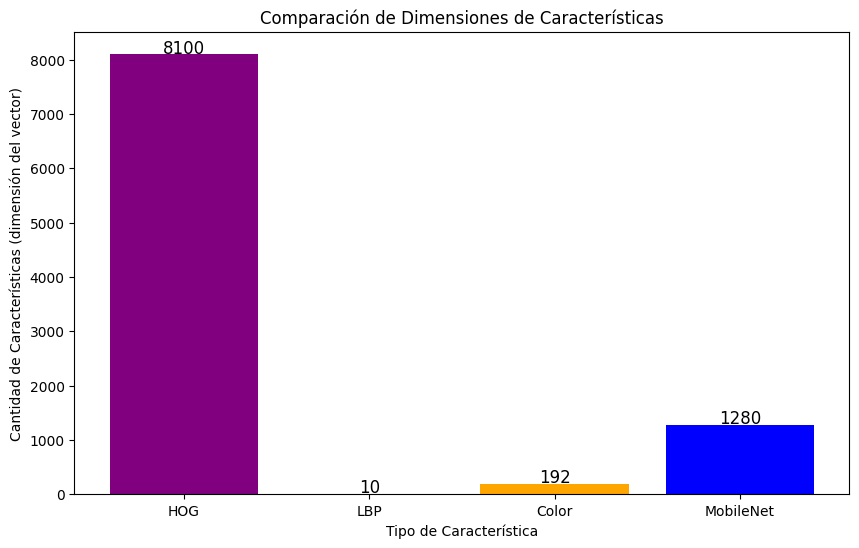

In [29]:
import matplotlib.pyplot as plt

# Dimensiones de cada vector de características
dim_hog = len(hog_features[0])
dim_lbp = len(lbp_features[0])
dim_color = len(color_features[0])
dim_mobilenet = len(mobile_features[0])

dims = [dim_hog, dim_lbp, dim_color, dim_mobilenet]
nombres = ["HOG", "LBP", "Color", "MobileNet"]

plt.figure(figsize=(10,6))
plt.bar(nombres, dims, color=["purple", "green", "orange", "blue"])
plt.title("Comparación de Dimensiones de Características")
plt.ylabel("Cantidad de Características (dimensión del vector)")
plt.xlabel("Tipo de Característica")

# Mostrar valor encima de cada barra
for i, d in enumerate(dims):
    plt.text(i, d + 20, str(d), ha='center', fontsize=12)

plt.show()

#**PARTE II-- Aprendizaje Supervisado**

Enfocada en el diseño, entrenamiento y evaluación de modelos

In [5]:
import numpy as np
import pandas as pd
import joblib
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
import seaborn as sns
import matplotlib.pyplot as plt

In [7]:
BASE = "/content/drive/MyDrive/Proyecto Final/caracteristicas_70clases_70imgs"

hog_features     = joblib.load(f"{BASE}/features_hog.pkl")
lbp_features     = joblib.load(f"{BASE}/features_lbp.pkl")
color_features   = joblib.load(f"{BASE}/features_color.pkl")
mobile_features  = joblib.load(f"{BASE}/features_mobilenet.pkl")
labels           = joblib.load(f"{BASE}/labels.pkl")
classes          = joblib.load(f"{BASE}/classes.pkl")

print("Datos cargados correctamente.")
print("Total muestras:", len(labels))
print("Clases seleccionadas:", len(classes))

Datos cargados correctamente.
Total muestras: 52805
Clases seleccionadas: 118


In [8]:
import numpy as np

# Convertir listas a arreglos 2D
hog_features = np.array(hog_features)
lbp_features = np.array(lbp_features)
color_features = np.array(color_features)
mobile_features = np.array(mobile_features)

# Mostrar dimensiones
print("HOG:", hog_features.shape)
print("LBP:", lbp_features.shape)
print("Color:", color_features.shape)
print("MobileNet:", mobile_features.shape)

# Concatenar todo
X = np.hstack([hog_features, lbp_features, color_features, mobile_features])
y = np.array(labels)

print("Dimensión total X:", X.shape)

HOG: (52805, 8100)
LBP: (52805, 10)
Color: (52805, 192)
MobileNet: (52805, 1280)
Dimensión total X: (52805, 9582)


In [1]:
print("Dimensión total del vector de características:", X.shape)

NameError: name 'X' is not defined

In [ ]:
X = np.hstack([hog_features, lbp_features, color_features, mobile_features])

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)